In [1]:
import sys
import os
import getpass

# Path to where your CaloQVAE dir is
upper_dir = 'SPVAE'
# Path to where your CaloQVAE dir is
os.chdir('/home/' + getpass.getuser() + f'/{upper_dir}' + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + f'/{upper_dir}' + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + f'/{upper_dir}/')

#external libraries
import os

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

# 定义归一化和反归一化函数
def _reduce(in_data, true_energy, R=1e-7):
    """
    CaloDiff Transformation Scheme
    """
    epsilon = in_data / true_energy
    x = R + (1 - 2 * R) * epsilon
    u = torch.log(x * (1 - R) / (R * (1 - x)))
    # 替换 NaN 为 0
    u = torch.nan_to_num(u, nan=0.0)
    return u

def _reduceinv(in_data, true_energy, R=1e-7):
    """
    CaloDiff Inverse Transformation Scheme
    """
    R_tensor = torch.tensor(R / (1 - R), dtype=in_data.dtype, device=in_data.device)
    zero_tensor = torch.tensor(0.0, dtype=in_data.dtype, device=in_data.device)
    
    x = (torch.sigmoid(in_data + torch.log(R_tensor)) - R) / (1 - 2 * R) * true_energy
    x[torch.isclose(x, zero_tensor)] = 0.0
    # 替换 NaN 为 0
    x = torch.nan_to_num(x, nan=0.0)
    return x

def non_zero_tensor(tensor):
    return tensor[tensor != 0]

In [3]:
n_samples = 10000

In [29]:
iterations = [1,5,9, 13, 18,22, 26, 30]

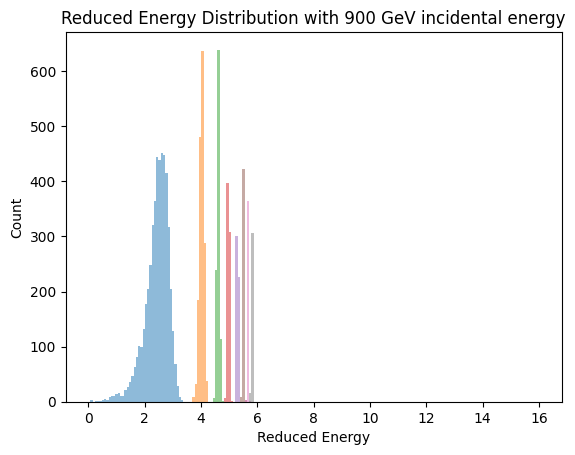

In [34]:
test_data_all =[]
for iteration in iterations:
    bin_size = 0.4
    n_samples_l = int(n_samples/(iteration+1))
    test_data = torch.randn(n_samples_l, 6480) * bin_size + iteration * 1
    energies = torch.ones(n_samples_l)*900000
    reduced_data = _reduce(test_data, energies.view(-1, 1))
    index = 100
    test_indexed = test_data[:,index]
    reduced_indexed = reduced_data[:,index]
    bins = np.linspace(0, 16, 200)
    plt.hist(non_zero_tensor(reduced_indexed).cpu().numpy(), bins=bins, alpha=0.5, label='reduced')
    test_data_all.append(test_indexed)
plt.title('Reduced Energy Distribution with 900 GeV incidental energy')
plt.xlabel('Reduced Energy')
plt.ylabel('Count')
plt.show()

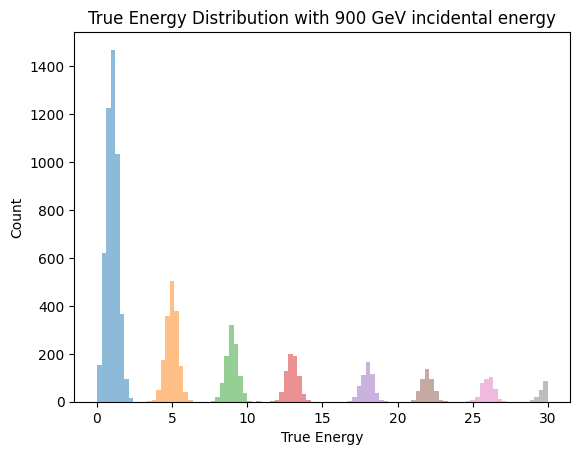

In [35]:
for test_data in test_data_all:
    binss= torch.linspace(0, 30, 100)
    plt.hist(test_data.cpu().numpy(), bins=binss, alpha=0.5, label='test')
plt.xlabel('True Energy')
plt.ylabel('Count')
plt.title('True Energy Distribution with 900 GeV incidental energy')
plt.show()

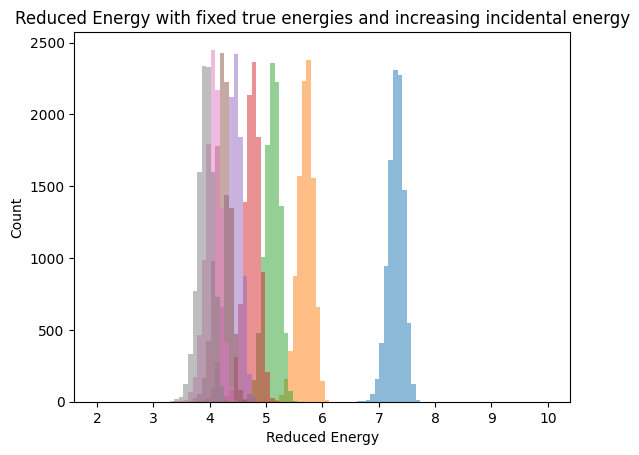

In [46]:
n_samples_l = 10000
test_data_all =[]
for iteration in iterations:
    bin_size =2
    n_samples_l = int(n_samples)
    test_data = torch.randn(n_samples_l, 6480)*bin_size +15
    energies = torch.ones(n_samples_l,1)*100000 * iteration
    reducedinv_data = _reduce(test_data, energies.view(-1, 1))
    index = 100
    test_indexed = test_data[:,index]
    reducedinv_indexed = reducedinv_data[:,index]
    bins = np.linspace(2, 10, 100)
    plt.hist(non_zero_tensor(reducedinv_indexed).cpu().numpy(), bins=bins, alpha=0.5, label='reducedinv')
    test_data_all.append(test_indexed)
plt.title('Reduced Energy with fixed true energies and increasing incidental energy')
plt.xlabel('Reduced Energy')
plt.ylabel('Count')
plt.show()